# Tree Methods Consulting Project

You've been hired by a dog food company to try to predict why some batches of their dog food are spoiling much quicker than intended! Unfortunately this Dog Food company hasn't upgraded to the latest machinery, meaning that the amounts of the five preservative chemicals they are using can vary a lot, but which is the chemical that has the strongest effect? The dog food company first mixes up a batch of preservative that contains 4 different preservative chemicals (A,B,C,D) and then is completed with a "filler" chemical. The food scientists beelive one of the A,B,C, or D preservatives is causing the problem, but need your help to figure out which one!
Use Machine Learning with RF to find out which parameter had the most predicitive power, thus finding out which chemical causes the early spoiling! So create a model and then find out how you can decide which chemical is the problem!

* Pres_A : Percentage of preservative A in the mix
* Pres_B : Percentage of preservative B in the mix
* Pres_C : Percentage of preservative C in the mix
* Pres_D : Percentage of preservative D in the mix
* Spoiled: Label indicating whether or not the dog food batch was spoiled.
___

**Think carefully about what this problem is really asking you to solve. While we will use Machine Learning to solve this, it won't be with your typical train/test split workflow. If this confuses you, skip ahead to the solution code along walk-through!**
____

## Import

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import (ttest_ind, 
                         f_oneway, mannwhitneyu, kruskal)
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from scipy.stats import pearsonr
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import mean, median, skewness, kurtosis, approx_count_distinct, format_number, sqrt
from pyspark.sql.types import StringType, DoubleType, LongType, StructType, StructField
from pyspark.sql.functions import (col, count, sum, 
                                    mean, min, max, round, cast)


def detect_datatype_and_plot(df, figsize=(10, 8)):
    # Loop through each column in the dataframe
    for column in df.columns:
        # Check if the column is numeric (continuous)
        if df.select(column).dtypes[0][1] in ['int', 'bigint', 'float', 'double']:
            # If it's numeric, plot a KDE/histogram
            plt.figure(figsize=figsize)
            sns.histplot(data=df.toPandas(), x=column, kde=True)
            plt.show()
        else:
            # If it's not numeric, count the distinct values and plot a bar chart
            distinct_count = df.select(countDistinct(col(column))).collect()[0][0]
            if distinct_count < 10:
                # For columns with fewer than 10 distinct values, use a bar chart
                plt.figure(figsize=figsize)
                sns.countplot(data=df.toPandas(), x=column, order=df.toPandas()[column].value_counts().index)
                plt.show()
            else:
                # For columns with more than 10 distinct values, use a horizontal bar chart
                plt.figure(figsize=(figsize[0], distinct_count / 2))
                sns.countplot(data=df.toPandas(), y=column, order=df.toPandas()[column].value_counts().index)
                plt.show()
                
                
                

                
                
                
                
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall_curve(model, test_data):
    # Make predictions on the test data
    predictions = model.transform(test_data).select(col("prediction"), col("Churn"))
    
    # Evaluate the model's performance using the BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="Churn")
    auc_score = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("AUC score: {:.3f}".format(auc_score))
    
    # Calculate precision and recall scores
    y_true = predictions.select(['Churn']).collect()
    y_scores = predictions.select(['prediction']).collect()
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    # Plot the precision-recall curve
    plt.plot(recall, precision, color='navy', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.show()
    
    # Print precision and recall scores
    print("Precision score: {:.3f}".format(precision.mean()))
    print("Recall score: {:.3f}".format(recall.mean()))
    
    
    
    
    
    
    
    
# functinon for null value checks:
def check_null(data):
    
    null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])
    
    return null_counts



# handy function for later when we add csv files as tables
def create_spark(table_name):
    
    data = sqlContext.sql(f"select * from {table_name}")
    data = spark.createDataFrame(data.rdd)
    
    return data






def continuous_vs_categorical(data_frame, continuous_col, categorical_col, plot_kind ='bar', 
                              distribution_assumption = True):
    
    if plot_kind not in ['strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar', 'count']:
        raise ValueError("plot_kind not one of 'strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar', 'count'")
    # Check the number of unique categories in the categorical column
    num_categories = data_frame.select(categorical_col).distinct().count()
    
    # If there are only two categories, perform t-test
    if num_categories == 2:
        # Get data for each category
        category1_data = data_frame.filter(col(categorical_col) == 1).select(continuous_col).rdd.flatMap(lambda x: x).collect()
        category2_data = data_frame.filter(col(categorical_col) == 0).select(continuous_col).rdd.flatMap(lambda x: x).collect()
        
        if distribution_assumption:
            # Perform t-test
            t_stat, p_value = ttest_ind(category1_data, category2_data)
            print("T-test statistic is {:.2f}, with p-value of {:.2f}".format(t_stat, p_value))
            
        else:
            # perform man whitney u test
            MWU_stat, p_value = mannwhitneyu(category1_data, category2_data)
            print("MWU statistic is {:.2f}, with p-value of {:.2f}".format(MWU_stat, p_value))

        # Create bar chart with error bars using Seaborn
        data = data_frame.select(categorical_col, continuous_col).toPandas()
        sns.catplot(x=categorical_col, y=continuous_col,
                    data=data, 
                    kind=plot_kind)
        plt.title("{} by {}".format(continuous_col, categorical_col))
        plt.show()
    
    # If there are more than two categories, perform ANOVA test
    elif num_categories > 2:
        # Get data for each category
        data_by_category = data_frame.groupBy(categorical_col).agg({continuous_col: 'collect_list'}).collect()
        category_data = [x[1] for x in data_by_category]
        
        if distribution_assumption:
            # Perform ANOVA test
            f_stat, p_value = f_oneway(*category_data)
            print("ANOVA F-statistic is {:.2f}, with p-value of {:.2f}".format(f_stat, p_value))
            
        else:
            # Perform ANOVA test
            krusk_stat, p_value = f_oneway(*category_data)
            print("Kruskal-Wallis Stat is {:.2f}, with p-value of {:.2f}".format(krusk_stat, p_value))

        # Create bar chart with error bars using Seaborn
        data = data_frame.select(categorical_col, continuous_col).toPandas()

        sns.catplot(x=categorical_col, y=continuous_col,
                    data=data, 
                    kind=plot_kind)
        
        plt.title("{} by {}".format(continuous_col, categorical_col))
        plt.show()
        
    # If there are no categories, print error message
    else:
        print("Error: no categories found in categorical column")
        


## Read and Analysis

In [0]:
data = create_spark('dog_food')
data.show()

+---+---+----+---+-------+
|  A|  B|   C|  D|Spoiled|
+---+---+----+---+-------+
|  4|  2|12.0|  3|    1.0|
|  5|  6|12.0|  7|    1.0|
|  6|  2|13.0|  6|    1.0|
|  4|  2|12.0|  1|    1.0|
|  4|  2|12.0|  3|    1.0|
| 10|  3|13.0|  9|    1.0|
|  8|  5|14.0|  5|    1.0|
|  5|  8|12.0|  8|    1.0|
|  6|  5|12.0|  9|    1.0|
|  3|  3|12.0|  1|    1.0|
|  9|  8|11.0|  3|    1.0|
|  1| 10|12.0|  3|    1.0|
|  1|  5|13.0| 10|    1.0|
|  2| 10|12.0|  6|    1.0|
|  1| 10|11.0|  4|    1.0|
|  5|  3|12.0|  2|    1.0|
|  4|  9|11.0|  8|    1.0|
|  5|  1|11.0|  1|    1.0|
|  4|  9|12.0| 10|    1.0|
|  5|  8|10.0|  9|    1.0|
+---+---+----+---+-------+
only showing top 20 rows



In [0]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|                 A|                 B|                 C|                 D|            Spoiled|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               490|               490|               490|               490|                490|
|   mean|  5.53469387755102| 5.504081632653061| 9.126530612244897| 5.579591836734694| 0.2857142857142857|
| stddev|2.9515204234399057|2.8537966089662063|2.0555451971054275|2.8548369309982857|0.45221563164613465|
|    min|                 1|                 1|               5.0|                 1|                0.0|
|    max|                10|                10|              14.0|                10|                1.0|
+-------+------------------+------------------+------------------+------------------+-------------------+



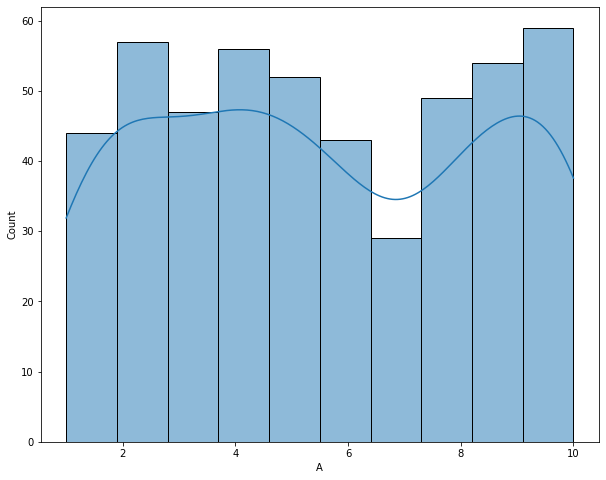

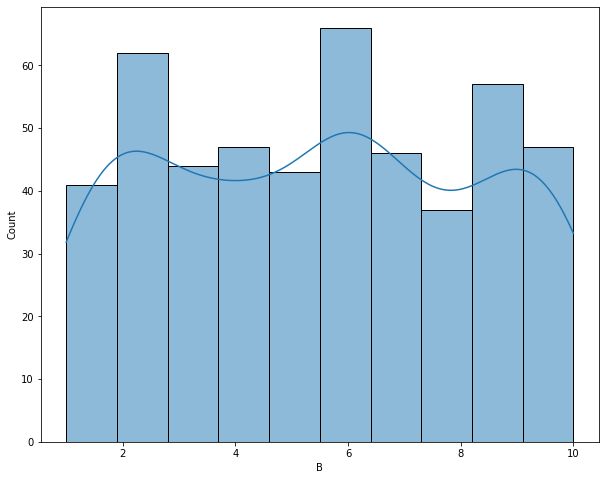

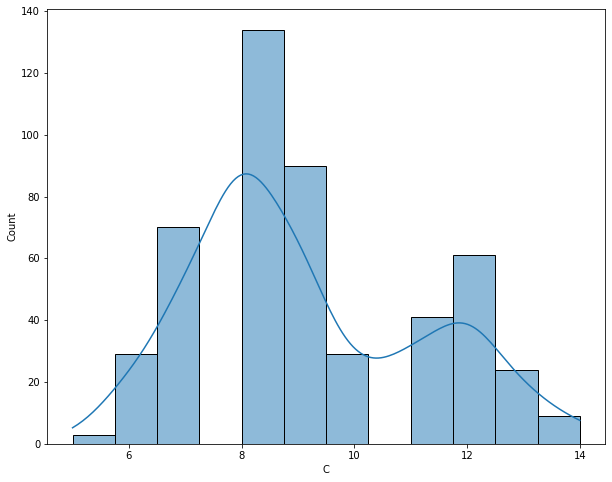

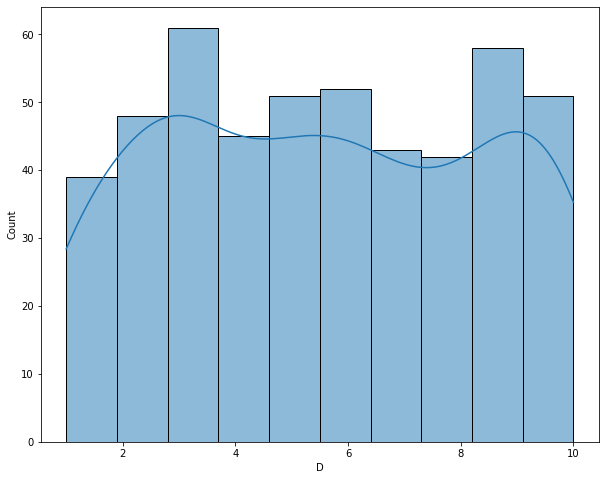

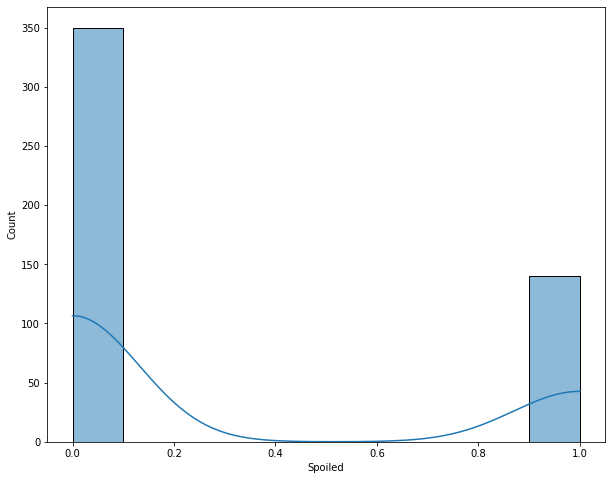

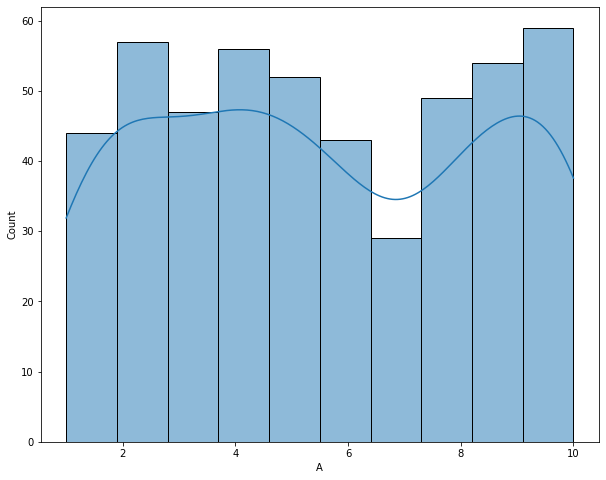

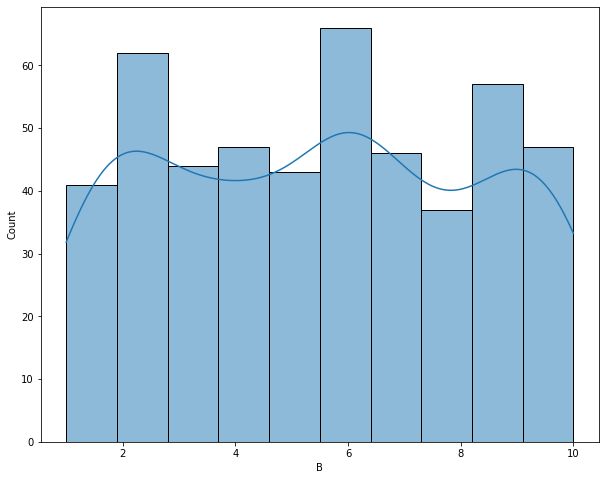

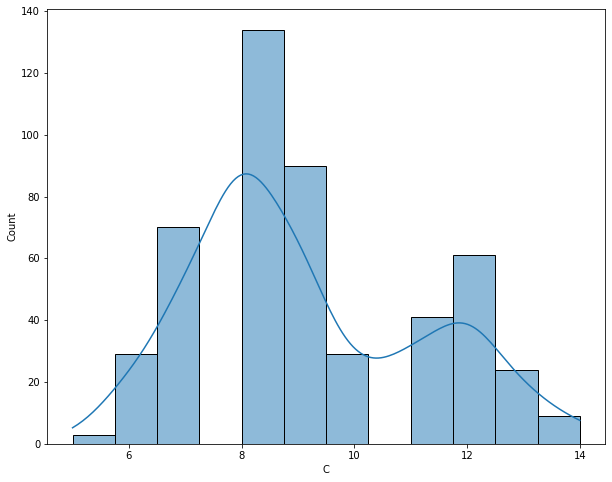

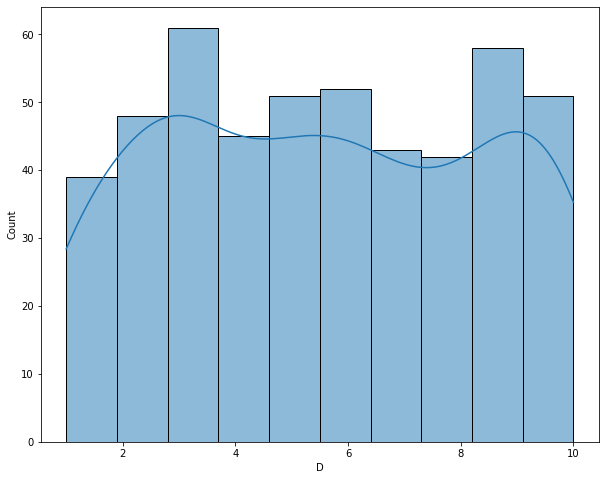

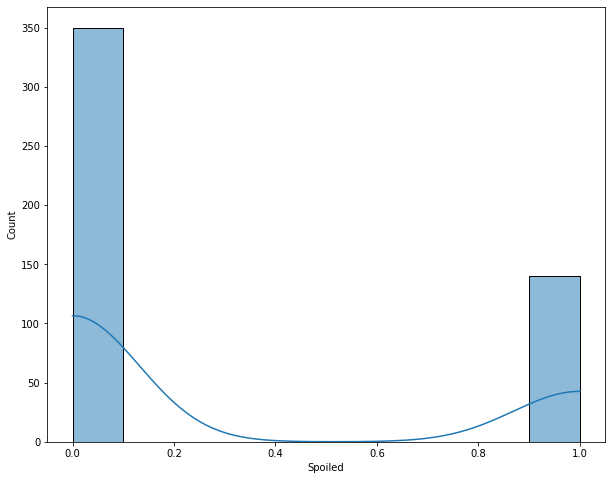

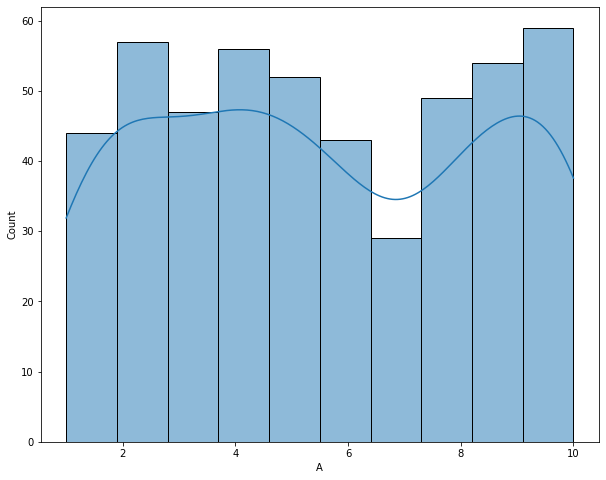

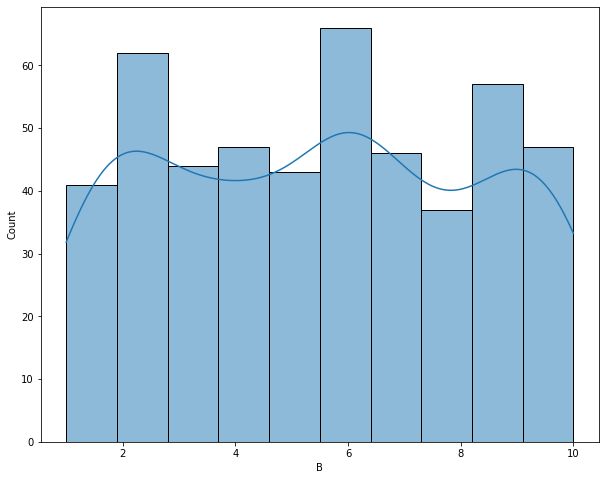

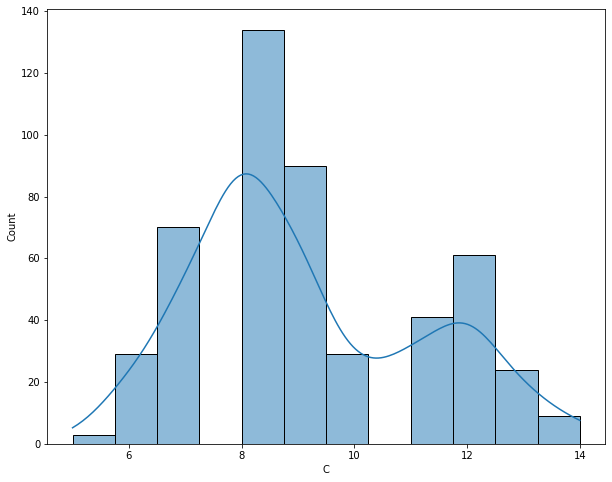

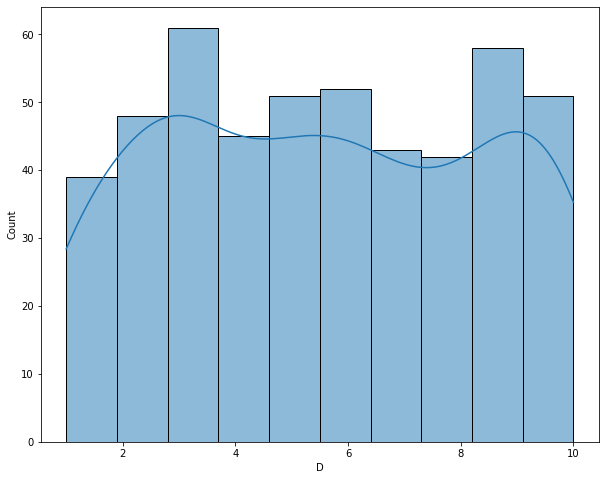

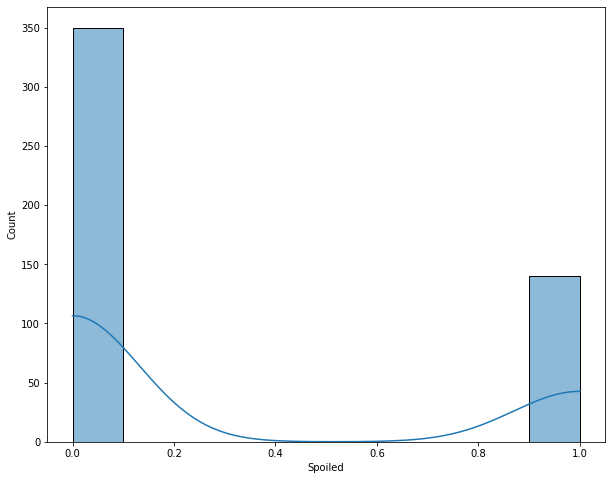

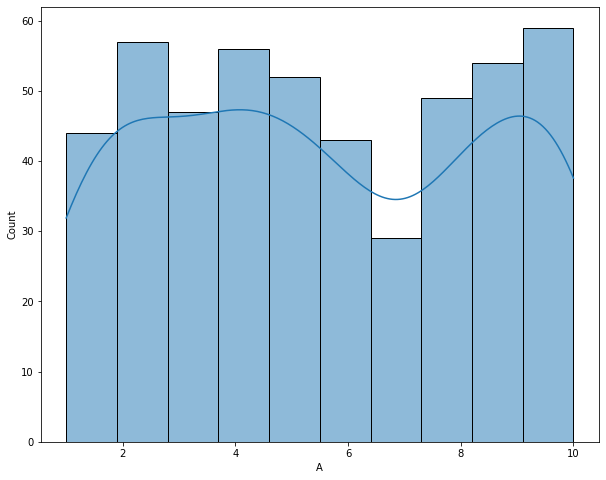

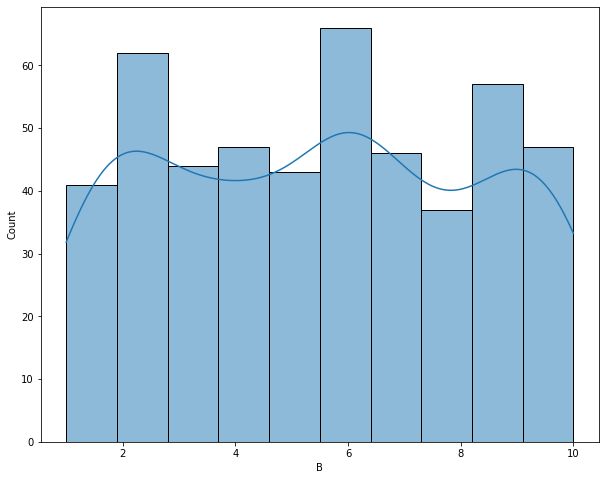

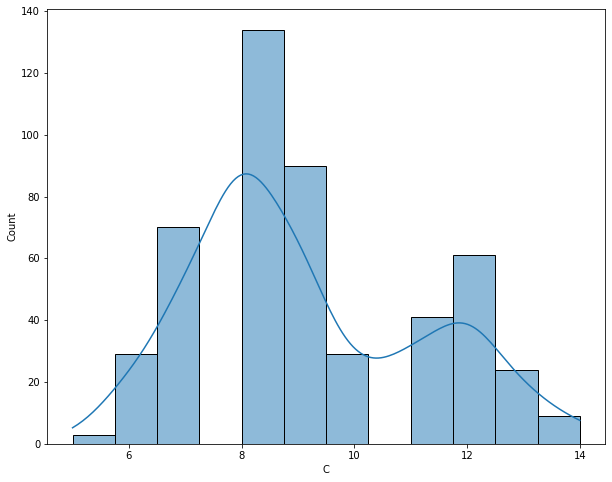

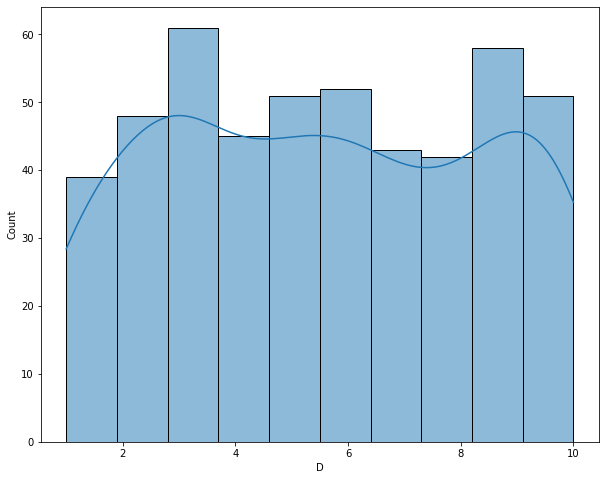

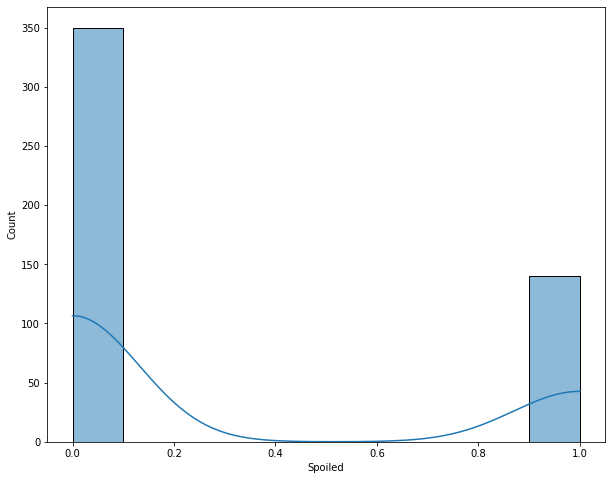

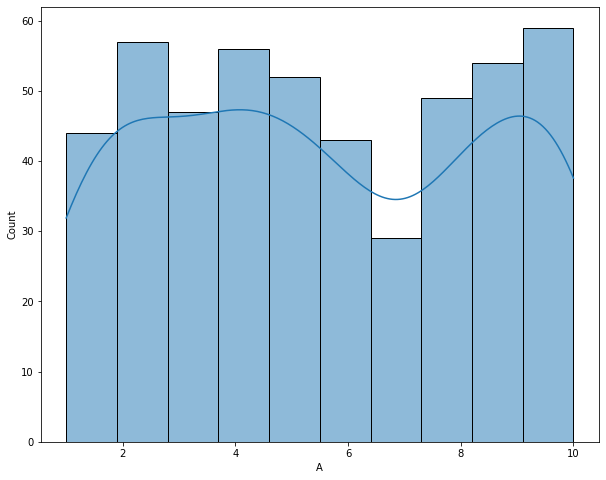

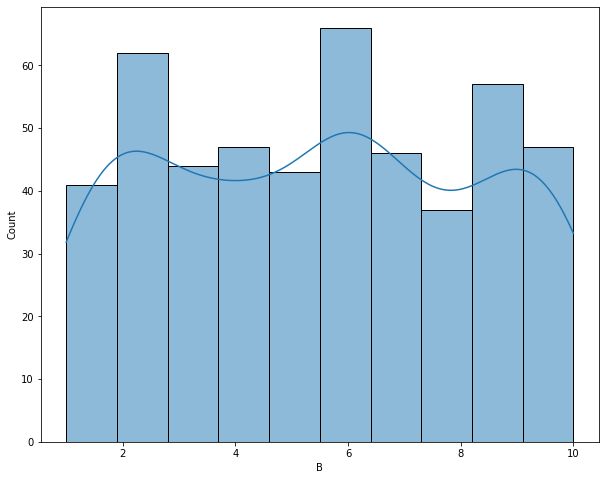

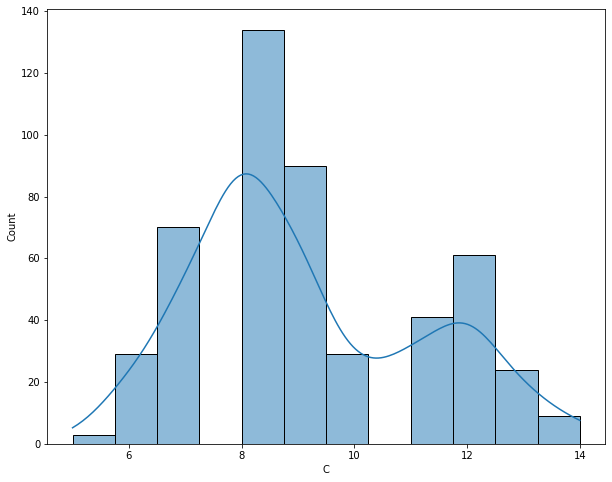

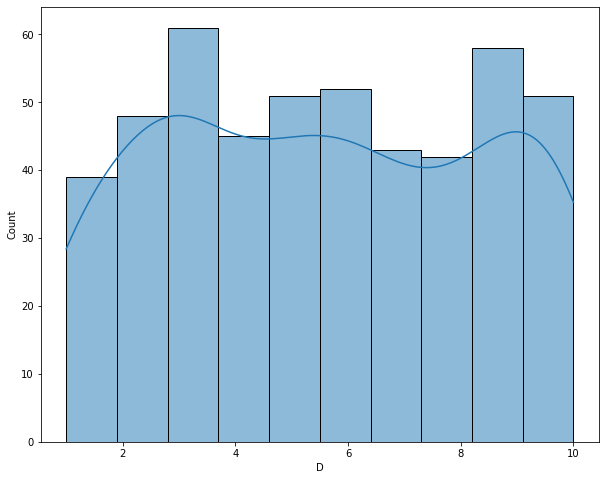

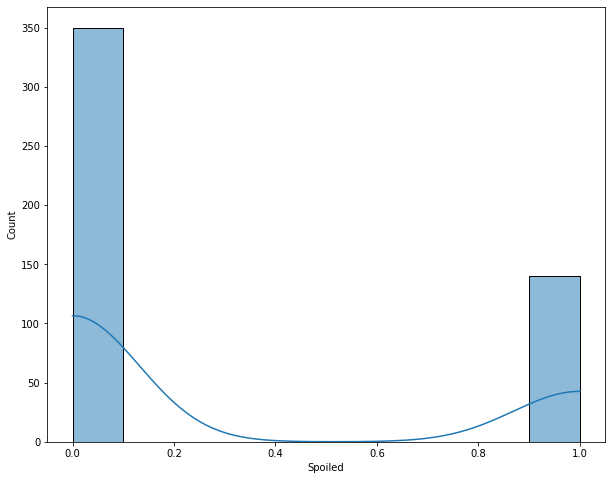

In [0]:
for column in data.columns:
    
    detect_datatype_and_plot(data)

COLUMN: A
MWU statistic is 26388.00, with p-value of 0.18


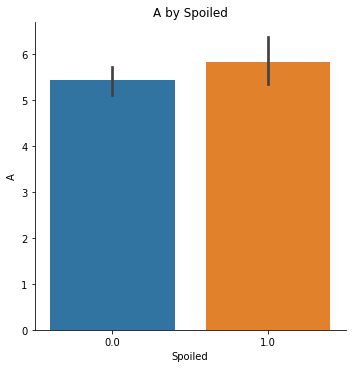

COLUMN: B
MWU statistic is 21793.00, with p-value of 0.05


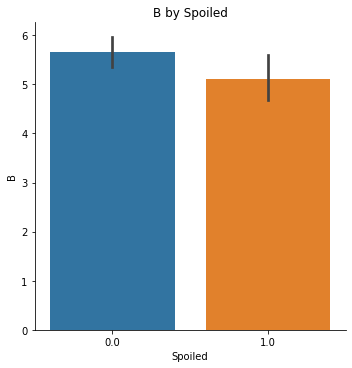

COLUMN: C
MWU statistic is 48810.50, with p-value of 0.00


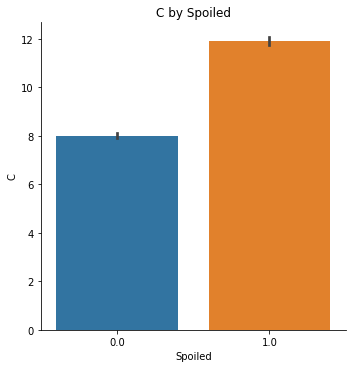

COLUMN: D
MWU statistic is 23966.00, with p-value of 0.70


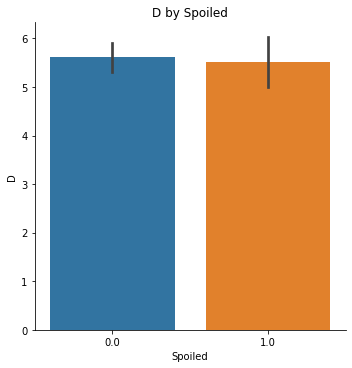

In [0]:
for column in [col for col in data.columns if col != 'Spoiled']:
    
    print(f"COLUMN: {column}")
    continuous_vs_categorical(data , continuous_col=column, categorical_col='Spoiled', distribution_assumption=False)

In [0]:
data.columns

Out[6]: ['A', 'B', 'C', 'D', 'Spoiled']

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['A', 'B', 'C', 'D'], outputCol='features')

data = assembler.transform(data)
data = data.withColumnRenamed('Spoiled', 'label')

# train

evaluator = BinaryClassificationEvaluator()
random_model = RandomForestClassifier(numTrees = 150)

model = random_model.fit(data)

In [0]:
# sparse vector needs turning into a list
importances = list(model.featureImportances)
importances

Out[23]: [0.020507249600159035,
 0.01899009504379513,
 0.9381164836952322,
 0.022386171660813695]

In [0]:
# create a list of (feature, importance) tuples
feature_importances = [[col, score] for col, score in zip(data.columns, importances)]


# create a dataframe of feature importances
importance_df = pd.DataFrame(feature_importances, columns=["feature", "importance"])
importance_df

,feature,importance
0,A,0.020507
1,B,0.018990
2,C,0.938116
3,D,0.022386


In [0]:
preds = model.transform(data)

auc = evaluator.evaluate(preds)

print(f'AUC: {auc}')

AUC: 0.9994897959183674


Our feature importances show how ingredient C is the most important feature for causing spoiling